## <span style="color:DarkGreen"> *1000hPa Comparison between Observations & The High Resolution Ensemble Forecast (HREF)* </span>

---
<div class="alert alert-block alert-success">
<b>Notes:</b> Each member treats the U, V and Geopotential Height variables differently, where the only pressure levels shared throughout all models for all variables are 1000, 850, 700, and 500 hPa 
</div>

#### **HREF Members Used:**

###### *- Advanced Research Weather (HRW WRF-ARW)*
###### *- Finite Volume Cubed Sphere (HRW WRF-FV3)*
###### *- National Severe Storms Laboratory (HRW WRF-NSSL)*
###### *- North American Model (NAM 3km CONUS)*
###### *- High Resolution Rapid Refresh (HRRR)*

#### **Observations Used:**
###### *- New York State Mesonet (NYSM)*
###### *- Automated Surface Observing Systems (ASOS)*

In [1]:
# HREF Initialization Time & NYSM Observation Starting Time
year = 2022 
month = 2 
day = 22
hour = 12
minute = 0 

# HREF Initialization Hour(s) (0, 6, 12, 18 UTC)
starthour = 12
endhour = 12

# Pressure Level (1000, 850, 700, 500 hPa)
Level = 1000

In [2]:
%matplotlib inline

# core
import os
import sys
import glob
import math
import cfgrib
import requests
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib as mpl

# Collections
from collections import Counter
from functools import reduce

# netCDF4
import netCDF4 as nc
from netCDF4 import Dataset

# datetime
import datetime as dt
from datetime import datetime,timedelta

#cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat 
from cartopy import feature as cfeature

# matplotlib
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.dates import DateFormatter, AutoDateLocator,HourLocator,DayLocator,MonthLocator

# metpy
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot, USCOUNTIES
from metpy.calc import wind_speed, wind_direction, relative_humidity_from_dewpoint, wind_components

In [3]:
inc = 1

#Load in field sites
sites = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/nysm/site_locations.txt')

#Getting coordinates for mesonet data because 2022 files dont have them
fpath_coords = '/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2019/20190902.nc'

# ASOS File Grabbing 
df_NY = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_NY_ASOS.csv')
df_VT = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_VT_ASOS.csv')
df_QE = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_QE_ASOS.csv')
df_ON = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_ON_ASOS.csv')

# NYSM File Grabbing
hour_delta = 0
minute_delta = 15
year_str = str(year)
month_str = str(month).zfill(2)
day_str = str(day).zfill(2)
hour_str = str(hour).zfill(2)
day2_str = str(day+1)
day3_str = str(day+2)   
base_dir = '/network/rit/lab/minderlab_rit/NYSM'
standard_dir = '/standard/netCDF/2022'
standard_1 = base_dir + standard_dir + '/' + year_str + month_str + day_str + '.nc'
standard_2 = base_dir + standard_dir + '/' + year_str + month_str + day2_str + '.nc'
standard_3 = base_dir + standard_dir + '/' + year_str + month_str + day3_str + '.nc'    
print('We are using the following paths to grab NYSM data:')
print(standard_1)
print(standard_2)
print(standard_3)
print()
NYSM_temp = xr.open_mfdataset([standard_1,standard_2,standard_3])
ds_coords = xr.open_dataset(fpath_coords)

####################################################################################
# HREF File Grabbing

href_base_dir = '/network/rit/lab/minderlab_rit/je845911/data/href'
yyyymmddhh_str = year_str + month_str + day_str + hour_str
yyyymmdd_str = yyyymmddhh_str[0:8]
yyyy_str = yyyymmddhh_str[0:4]
endhour = endhour +1
fhrs = np.arange(starthour,endhour,inc)
length = len(fhrs)
# ARW
arw = []
for fhr in fhrs:
    arw.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusarw_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2') # PROB WITH 0f0

# FV3
fv3 = []
for fhr in fhrs:
    fv3.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusfv3_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NSSL
nssl = []
for fhr in fhrs:
    nssl.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusnssl_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NCEP
ncep = []
for fhr in fhrs:
    ncep.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hrrr_ncep_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

# NAM
nam = []
for fhr in fhrs:
    nam.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/nam_conusnest_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

print("We are using the following paths to grab HREF data:")
for fpath in arw:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in fv3:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in nssl:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in ncep:
    print(fpath)
print()
print("We are using the following paths to grab HREF data:")
for fpath in nam:
    print(fpath)

We are using the following paths to grab NYSM data:
/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2022/20220222.nc
/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2022/20220223.nc
/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2022/20220224.nc

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/hiresw_conusarw_2022022212f012.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/hiresw_conusfv3_2022022212f012.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/hiresw_conusnssl_2022022212f012.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/hrrr_ncep_2022022212f012.grib2

We are using the following paths to grab HREF data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220222/nam_conusnest

/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cartop

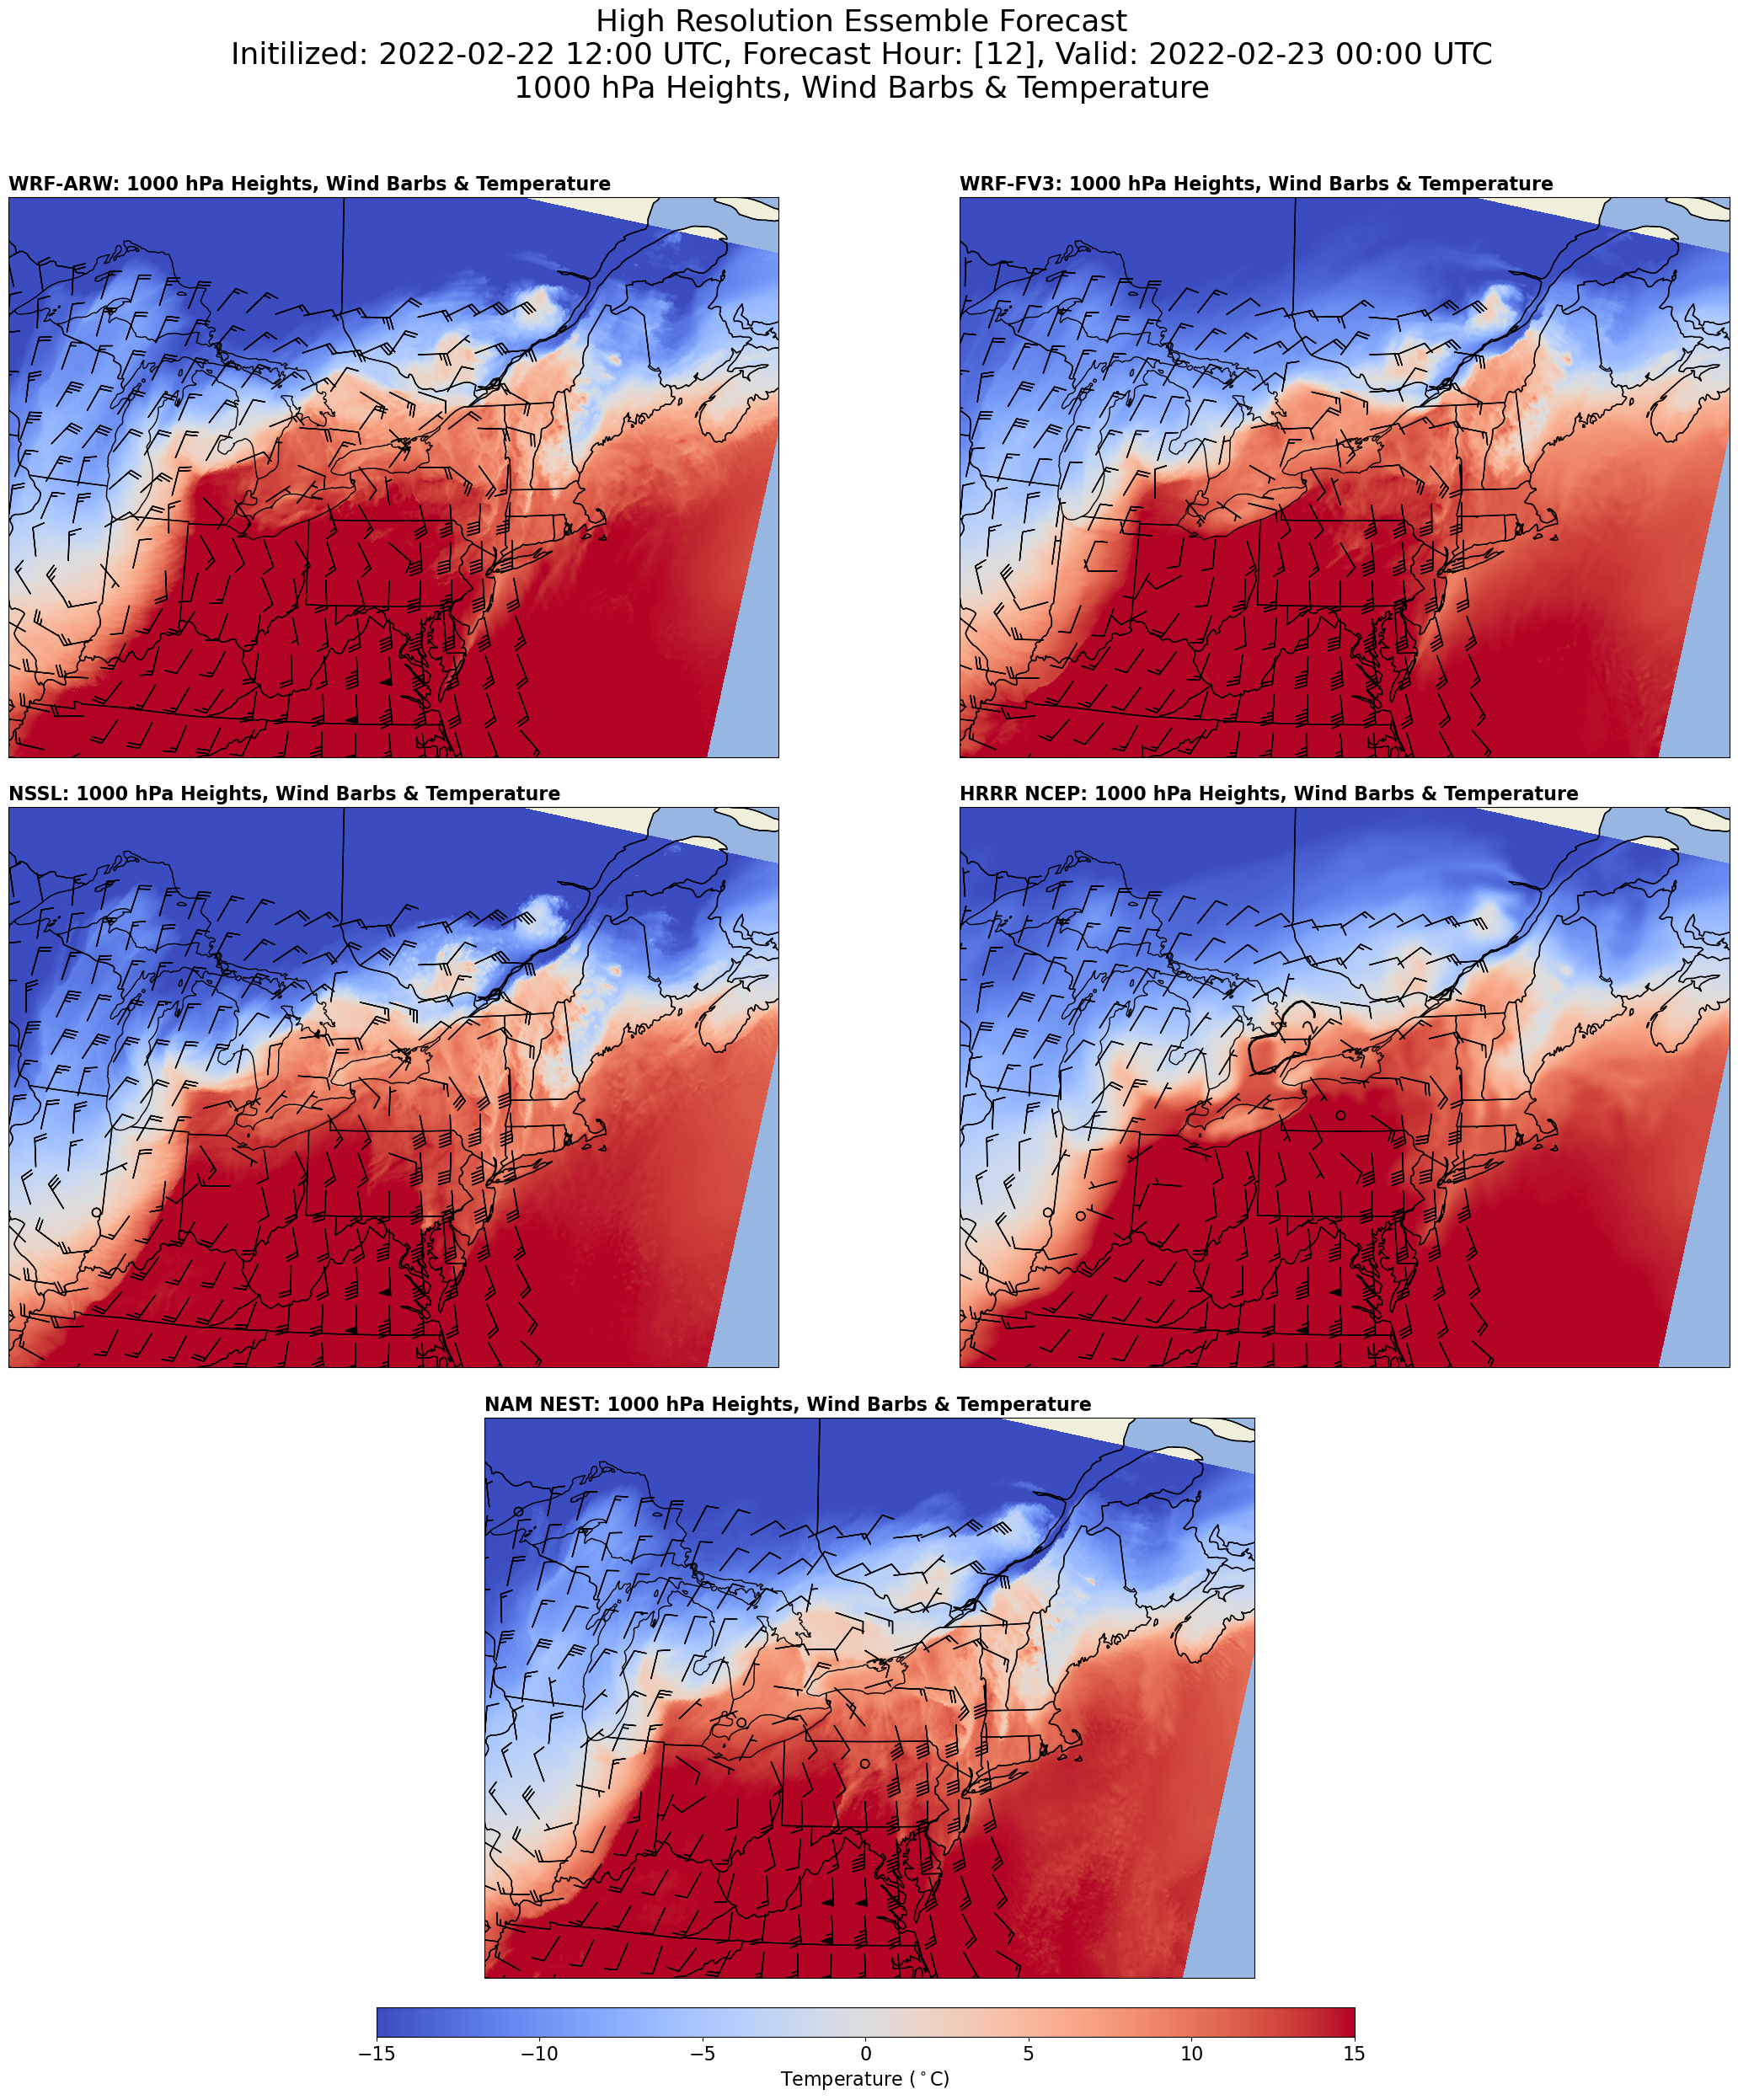

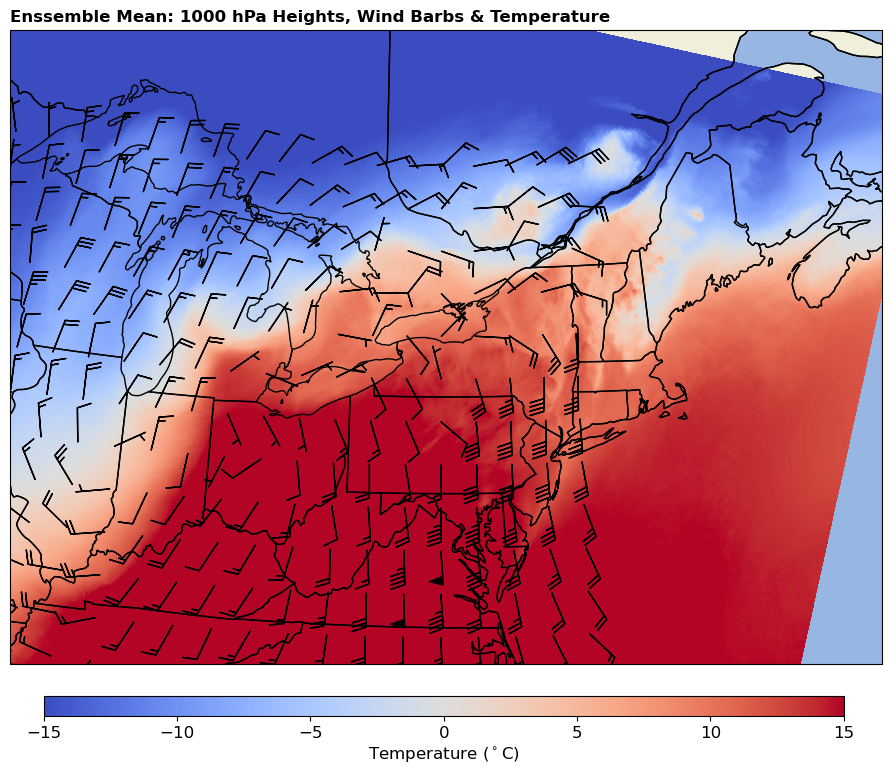

In [4]:
valid_time = datetime(year,month,day,hour,minute)
valid_time_str = valid_time.strftime("%Y-%m-%d %H:%M") 
hr = valid_time+dt.timedelta(minutes=minute_delta)
time = hr.strftime("%Y-%m-%d %H:%M") 

# Slice Wind Datasets by 3rd dimesion to specify isobaric pressure level for winds.
Level = str(Level) # ONLY 1000, 850, 700, 500 

if Level == '250':
    #iso = ?
    #iso_ncep = ?
    #iso_nam = 4
    a=a
elif Level == '500':
    iso = 4
    iso_ncep = 3
    iso_nam = 3
elif Level == '700':
    iso = 3
    iso_ncep = 2
    iso_nam = 2
elif Level == '850':
    iso = 2
    iso_ncep = 1
    iso_nam = 1
elif Level == '925':
    #iso = 1
    #iso_ncep = ?
    #iso_nam = ?
    a=a
elif Level == '1000':
    iso = 0
    iso_ncep = 0
    iso_nam = 0
    
    
# NEUS
lonW = -90 
lonE = -65
latS = 35
latN = 50
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
skip = 40


for i in fhrs:
      
    # Time
    D = int(((i-starthour)/inc)) # Used for HREF File Reference  
    time = (hr) + timedelta(hours=float(i)) 
    adjtime = time - dt.timedelta(minutes=minute_delta)
    adjtimestr = adjtime.strftime("%Y-%m-%d %H:%M") 
    nysm_adjtime = time.strftime("%H:%M")
    time_delta = (hr) - timedelta(hours=hour_delta, minutes=minute_delta)
    time_delta_str = time_delta.strftime("%Y-%m-%d %H:%M") 
    titlestrend = adjtime.strftime("%Y-%m-%d %H:%M")
    
        # ARW Temp (1000,925,850,700,500)
    with xr.open_mfdataset(arw[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':130},concat_dim = 'valid_time',combine = 'nested') as arw_t:
        arw_t = arw_t['t']-273.15
        arw_t = arw_t[0,iso,:,:]
        
        # ARW U-wind 
    with xr.open_mfdataset(arw[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':131},concat_dim = 'valid_time',combine = 'nested') as arw_u:
        arw_u = arw_u['u']*1.94384
        arw_u = arw_u[0,iso,:,:]
        
        # ARW V-wind 
    with xr.open_mfdataset(arw[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':132},concat_dim = 'valid_time',combine = 'nested') as arw_v:
        arw_v = arw_v['v']*1.94384 #m s^-1 to knots
        arw_v = arw_v[0,iso,:,:]
        
        # ARW Geopotential Height
    with xr.open_dataset(arw[D], engine = 'cfgrib',filter_by_keys={'typeOfLevel': 'isobaricInhPa', 'paramId': 156}) as arw_geo:
        arw_geo = arw_geo['gh']/10
        arw_geo = arw_geo.values
        arw_geo = np.around(arw_geo)
        arw_geo = arw_geo.astype(int)
        arw_geo = arw_geo[iso,:,:]
        
        # FV3 Temp (1000,925,850,700,500)
    with xr.open_mfdataset(fv3[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':130},concat_dim = 'valid_time',combine = 'nested') as fv3_t:
        fv3_t = fv3_t['t']-273.15
        fv3_t = fv3_t[0,iso,:,:]
        
        # FV3 U-wind 
    with xr.open_mfdataset(fv3[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':131},concat_dim = 'valid_time',combine = 'nested') as fv3_u:
        fv3_u = fv3_u['u']*1.94384
        fv3_u = fv3_u[0,iso,:,:]
        
        # FV3 V-wind 
    with xr.open_mfdataset(fv3[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':132},concat_dim = 'valid_time',combine = 'nested') as fv3_v:
        fv3_v = fv3_v['v']*1.94384 #m s^-1 to knots
        fv3_v = fv3_v[0,iso,:,:]
        
        # FV3 Geopotential Height
    with xr.open_dataset(fv3[D], engine = 'cfgrib',filter_by_keys={'typeOfLevel': 'isobaricInhPa', 'paramId': 156}) as fv3_geo:
        fv3_geo = fv3_geo['gh']/10
        fv3_geo = fv3_geo.values
        fv3_geo = np.around(fv3_geo)
        fv3_geo = fv3_geo.astype(int)
        fv3_geo = fv3_geo[iso,:,:]

        # NSSL Temp (1000,925,850,700,500)
    with xr.open_mfdataset(nssl[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':130},concat_dim = 'valid_time',combine = 'nested') as nssl_t:
        nssl_t = nssl_t['t']-273.15
        nssl_t = nssl_t[0,iso,:,:]
        
        # NSSL U-wind 
    with xr.open_mfdataset(nssl[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':131},concat_dim = 'valid_time',combine = 'nested') as nssl_u:
        nssl_u = nssl_u['u']*1.94384
        nssl_u = nssl_u[0,iso,:,:]
        
        # NSSL V-wind 
    with xr.open_mfdataset(nssl[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':132},concat_dim = 'valid_time',combine = 'nested') as nssl_v:
        nssl_v = nssl_v['v']*1.94384 #m s^-1 to knots
        nssl_v = nssl_v[0,iso,:,:]
        
        # NSSL Geopotential Height
    with xr.open_dataset(nssl[D], engine = 'cfgrib',filter_by_keys={'typeOfLevel': 'isobaricInhPa', 'paramId': 156}) as nssl_geo:
        nssl_geo = nssl_geo['gh']/10
        nssl_geo = nssl_geo.values
        nssl_geo = np.around(nssl_geo)
        nssl_geo = nssl_geo.astype(int)
        nssl_geo = nssl_geo[iso,:,:]

        # NCEP Temp (1000,925,850,700,500)
    with xr.open_mfdataset(ncep[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':130},concat_dim = 'valid_time',combine = 'nested') as ncep_t:
        ncep_t = ncep_t['t']-273.15
        ncep_t = ncep_t[0,iso,:,:]
        
        # NCEP U-wind 
    with xr.open_mfdataset(ncep[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':131},concat_dim = 'valid_time',combine = 'nested') as ncep_u:
        ncep_u = ncep_u['u']*1.94384
        ncep_u = ncep_u[0,iso,:,:]
        
        # NCEP V-wind 
    with xr.open_mfdataset(ncep[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':132},concat_dim = 'valid_time',combine = 'nested') as ncep_v:
        ncep_v = ncep_v['v']*1.94384 #m s^-1 to knots
        ncep_v = ncep_v[0,iso,:,:]
        
        # NCEP Geopotential Height
    with xr.open_dataset(ncep[D], engine = 'cfgrib',filter_by_keys={'typeOfLevel': 'isobaricInhPa', 'paramId': 156}) as ncep_geo:
        ncep_geo = ncep_geo['gh']/10
        ncep_geo = ncep_geo.values
        ncep_geo = np.around(ncep_geo)
        ncep_geo = ncep_geo.astype(int)
        ncep_geo = ncep_geo[iso_ncep,:,:]
           
        # NAM Temp (1000,925,850,700,500,250)
    with xr.open_mfdataset(nam[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':130},concat_dim = 'valid_time',combine = 'nested') as nam_t:
        nam_t = nam_t['t']-273.15
        nam_t = nam_t[0,iso,:,:]
    
        # NAM U-wind 
    with xr.open_mfdataset(nam[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':131},concat_dim = 'valid_time',combine = 'nested') as nam_u:
        nam_u = nam_u['u']*1.94384
        nam_u = nam_u[0,iso,:,:]
        
        # NAM V-wind 
    with xr.open_mfdataset(nam[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':132},concat_dim = 'valid_time',combine = 'nested') as nam_v:
        nam_v = nam_v['v']*1.94384 #m s^-1 to knots
        nam_v = nam_v[0,iso,:,:]
        
        # NAM Geopotential Height
    with xr.open_dataset(nam[D], engine = 'cfgrib',filter_by_keys={'typeOfLevel': 'isobaricInhPa', 'paramId': 156}) as nam_geo:
        nam_geo = nam_geo['gh']/10
        nam_geo = nam_geo.values
        nam_geo = np.around(nam_geo)
        nam_geo = nam_geo.astype(int)
        nam_geo = nam_geo[iso_nam,:,:]
        
    LAT = fv3_u['latitude']
    LON = fv3_v['longitude']
    LON_winds = LON[0,:]
    LAT_winds = LAT[:,0]

    # Mean Temperature
    mean_t = ((arw_t + fv3_t + nssl_t + ncep_t + nam_t)/5)
    
    # Mean U & V Wind Components
    mean_u = ((arw_u + fv3_u + nssl_u + ncep_u + nam_u)/5)
    mean_v = ((arw_v + fv3_v + nssl_v + ncep_v + nam_v)/5)
    
    # Geopotential Height Adjustments
    levels_geo=np.arange(100,200,3)
    mean_geo = ((arw_geo + fv3_geo + nssl_geo + ncep_geo + nam_geo)/5)
    
    # Defiining Figure Features
    def features(ax):
        ax.set_extent ([lonW,lonE,latS,latN])
        ax.add_feature (cfeature.LAND.with_scale(res), zorder=1)
        ax.add_feature (cfeature.OCEAN.with_scale(res), zorder=1)
        ax.add_feature (cfeature.LAKES.with_scale(res), zorder=1)
        ax.add_feature(cfeature.COASTLINE.with_scale(res), zorder = 3)
        ax.add_feature (cfeature.STATES.with_scale(res), zorder = 3)
        
    # Title
    tl0,tl1,tl2 = 'High Resolution Essemble Forecast',f'{Level} hPa Heights, Wind Barbs & Temperature', f'Initilized: {valid_time_str} UTC, Forecast Hour: [{i}], Valid: {titlestrend} UTC'
    title_line = (tl0+ '\n' + tl2 + '\n' + tl1)
    variable = f' {Level} hPa Heights, Wind Barbs & Temperature'
    model1_t,model2_t,model3_t,model4_t,model5_t,model6_t = 'WRF-ARW:','WRF-FV3:','NSSL:','HRRR NCEP:','NAM NEST:','Enssemble Mean:'
    titletime = valid_time.strftime("%Y%m%d%H") 

    # ASOS & NYSM Features
    color ='black'
    fontsize = 12
    county_lw, county_scale = 1.0, '5m'
    cbarna = 'coolwarm' #'jet'
    
    #values = NYSM_temp.values
    MAX = 15 # 20 max(values) 
    MIN = -15 # -20 min(values)
    norm = mpl.colors.Normalize(MIN, MAX)
    
    # Figure Features
    res = '50m'
    proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
    msize = 110
    
    # Surface Temperature Figure
    fig = plt.figure(figsize=(36,28),dpi=100)
    plt.suptitle(title_line, x = .51, y = .96, fontsize = 26)
    plt.subplots_adjust(left = None, bottom = None, right = None, top = None, wspace = -.32, hspace = .09)
    
    ax1 = fig.add_subplot(3,2,1, projection=proj)
    ax1.set_title(model1_t + variable,fontsize=16,loc = 'left',fontweight = 'bold')
    features(ax1)  
    ax1.barbs(LON_winds[::skip],LAT_winds[::skip],arw_u[::skip,::skip].values,arw_v[::skip,::skip].values, transform=ccrs.PlateCarree(), zorder = 5)    
    GEO = ax1.contour(LON, LAT, arw_geo, colors = 'k', linewidths = 2,transform = ccrs.PlateCarree(),levels = levels_geo, zorder = 6) 
    plt.clabel(GEO,inline=1,fontsize=16,fmt='%.0f', zorder = 6)
    TEMP = ax1.pcolormesh(LON, LAT, arw_t, shading = 'auto', zorder = 2, alpha = 1, cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())
  
    ax2 = fig.add_subplot(3,2,2, projection=proj)
    ax2.set_title(model2_t + variable,fontsize=16,loc = 'left',fontweight = 'bold')
    features(ax2)  
    ax2.barbs(LON_winds[::skip],LAT_winds[::skip],fv3_u[::skip,::skip].values,fv3_v[::skip,::skip].values, transform=ccrs.PlateCarree(), zorder = 5)    
    GEO = ax2.contour(LON, LAT, fv3_geo, colors = 'k', linewidths = 2,transform = ccrs.PlateCarree(),levels = levels_geo, zorder = 6) 
    plt.clabel(GEO,inline=1,fontsize=16,fmt='%.0f', zorder = 6)
    TEMP = ax2.pcolormesh(LON, LAT, fv3_t, shading = 'auto', zorder = 2, alpha = 1, cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())
    
    ax3 = fig.add_subplot(3,2,3, projection=proj)
    ax3.set_title(model3_t + variable,fontsize=16,loc = 'left',fontweight = 'bold')
    features(ax3)  
    ax3.barbs(LON_winds[::skip],LAT_winds[::skip],nssl_u[::skip,::skip].values,nssl_v[::skip,::skip].values, transform=ccrs.PlateCarree(), zorder = 5)    
    GEO = ax3.contour(LON, LAT, nssl_geo, colors = 'k', linewidths = 2,transform = ccrs.PlateCarree(),levels = levels_geo, zorder = 6) 
    plt.clabel(GEO,inline=1,fontsize=16,fmt='%.0f', zorder = 6)
    TEMP = ax3.pcolormesh(LON, LAT, nssl_t, shading = 'auto', zorder = 2, alpha = 1, cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())

    ax4 = fig.add_subplot(3,2,4, projection=proj)
    ax4.set_title(model4_t + variable,fontsize=16,loc = 'left',fontweight = 'bold')
    features(ax4)  
    ax4.barbs(LON_winds[::skip],LAT_winds[::skip],ncep_u[::skip,::skip].values,ncep_v[::skip,::skip].values, transform=ccrs.PlateCarree(), zorder = 5)    
    GEO = ax4.contour(LON, LAT, ncep_geo, colors = 'k', linewidths = 2,transform = ccrs.PlateCarree(),levels = levels_geo, zorder = 6) 
    plt.clabel(GEO,inline=1,fontsize=16,fmt='%.0f', zorder = 6)
    TEMP = ax4.pcolormesh(LON, LAT, ncep_t, shading = 'auto', zorder = 2, alpha = 1, cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())

    ax5 = fig.add_subplot(3,1,3, projection=proj)
    ax5.set_title(model5_t + variable,fontsize=16,loc = 'left',fontweight = 'bold')
    features(ax5)  
    ax5.barbs(LON_winds[::skip],LAT_winds[::skip],nam_u[::skip,::skip].values,nam_v[::skip,::skip].values, transform=ccrs.PlateCarree(), zorder = 5)    
    GEO = ax5.contour(LON, LAT, nam_geo, colors = 'k', linewidths = 2,transform = ccrs.PlateCarree(),levels = levels_geo, zorder = 6) 
    plt.clabel(GEO,inline=1,fontsize=16,fmt='%.0f', zorder = 6)
    TEMP = ax5.pcolormesh(LON, LAT, nam_t, shading = 'auto', zorder = 2, alpha = 1, cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())
    
    colorbar_axes = fig.add_axes([0.35, 0.1, .3225, .0125])# Left Bottom Width Height
    cbar = plt.colorbar(TEMP, shrink=0.5, cax = colorbar_axes, orientation = 'horizontal')
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_xlabel("Temperature ($^\circ$C)",fontsize=16)
    
    savefiguretitle = f'{Level}hPa_{str(titletime)}_{str(i).zfill(2)}'
    fig.savefig(savefiguretitle)

    # Surface Temperature Figure
    fig = plt.figure(figsize=(11.25,11.25),dpi=100)
    ax0 = fig.add_subplot(1,1,1, projection=proj)
    ax0.set_title(model6_t + variable,fontsize=12,fontweight = 'bold',loc = 'left')
    features(ax0)
    ax0.barbs(LON_winds[::skip],LAT_winds[::skip],mean_u[::skip,::skip].values,mean_v[::skip,::skip].values, transform=ccrs.PlateCarree(), zorder = 5)    
    GEO = ax0.contour(LON, LAT, mean_geo, colors = 'k', linewidths = 2,transform = ccrs.PlateCarree(),levels = levels_geo, zorder = 6) 
    plt.clabel(GEO,inline=1,fontsize=12,fmt='%.0f', zorder = 6)
    TEMP = ax0.pcolormesh(LON, LAT, mean_t, shading = 'auto', zorder = 2, alpha = 1, cmap = cbarna,norm=norm, transform = ccrs.PlateCarree())

    colorbar_axes = fig.add_axes([0.155, 0.175, .711, .0175])# Left Bottom Width Height
    cbar = plt.colorbar(TEMP, shrink=0.15, cax = colorbar_axes, orientation = 'horizontal')
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.set_xlabel("Temperature ($^\circ$C)",fontsize=12)
    
    savefiguretitle = f'{Level}hPa_mean_{str(titletime)}_{str(i).zfill(2)}'
    fig.savefig(savefiguretitle)
